In [ ]:
# !pip install kagglehub

In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

In [ ]:
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    'ravindrasinghrana/employeedataset/versions/2',
    'employee_data.csv',
)

In [4]:
df_employees = df.copy()

# Inspect Data

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df_employees.head()

,EmpID,FirstName,LastName,StartDate,ExitDate,Title,Supervisor,ADEmail,BusinessUnit,EmployeeStatus,...,Division,DOB,State,JobFunctionDescription,GenderCode,LocationCode,RaceDesc,MaritalDesc,Performance Score,Current Employee Rating
0,3427,Uriah,Bridges,20-Sep-19,NaN,Production Technician I,Peter Oneill,uriah.bridges@bilearner.com,CCDR,Active,...,Finance & Accounting,07-10-1969,MA,Accounting,Female,34904,White,Widowed,Fully Meets,4
1,3428,Paula,Small,11-Feb-23,NaN,Production Technician I,Renee Mccormick,paula.small@bilearner.com,EW,Active,...,Aerial,30-08-1965,MA,Labor,Male,6593,Hispanic,Widowed,Fully Meets,3
2,3429,Edward,Buck,10-Dec-18,NaN,Area Sales Manager,Crystal Walker,edward.buck@bilearner.com,PL,Active,...,General - Sga,06-10-1991,MA,Assistant,Male,2330,Hispanic,Widowed,Fully Meets,4
3,3430,Michael,Riordan,21-Jun-21,NaN,Area Sales Manager,Rebekah Wright,michael.riordan@bilearner.com,CCDR,Active,...,Finance & Accounting,04-04-1998,ND,Clerk,Male,58782,Other,Single,Fully Meets,2
4,3431,Jasmine,Onque,29-Jun-19,NaN,Area Sales Manager,Jason Kim,jasmine.onque@bilearner.com,TNS,Active,...,General - Con,29-08-1969,FL,Laborer,Female,33174,Other,Married,Fully Meets,3


In [7]:
df_employees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   EmpID                       3000 non-null   int64 
 1   FirstName                   3000 non-null   object
 2   LastName                    3000 non-null   object
 3   StartDate                   3000 non-null   object
 4   ExitDate                    1533 non-null   object
 5   Title                       3000 non-null   object
 6   Supervisor                  3000 non-null   object
 7   ADEmail                     3000 non-null   object
 8   BusinessUnit                3000 non-null   object
 9   EmployeeStatus              3000 non-null   object
 10  EmployeeType                3000 non-null   object
 11  PayZone                     3000 non-null   object
 12  EmployeeClassificationType  3000 non-null   object
 13  TerminationType             3000 non-null   obje

# Prepare Data

Check for duplicate values in 'EmpID' which is supposed to be dataset's primary key

In [9]:
df_employees['EmpID'].duplicated().sum()

0

Transform date columns into datetime format

In [10]:
df_employees['DOB'] = pd.to_datetime(df_employees['DOB'], format = '%d-%m-%Y')
df_employees['StartDate'] = pd.to_datetime(df_employees['StartDate'], format='%d-%b-%y')
df_employees['ExitDate'] = pd.to_datetime(df_employees['ExitDate'], format='%d-%b-%y')

In [11]:
# Create new Age column, age as of '01-01-2025'
date_ref = pd.to_datetime('01-01-2025', format = '%d-%m-%Y')
df_employees['Age'] = date_ref.year - df_employees['DOB'].dt.year

# Minus age by 1 if the employee hasn't had their birthday yet in 2025
df_employees['Age'] -= (date_ref.month < df_employees['DOB'].dt.month) | (date_ref.day < df_employees['DOB'].dt.day)

In [12]:
# Create new Tenure column
## For employees with an ExitDate, calculate the tenure as the difference between ExitDate and StartDate
## For employees without an ExitDate, calculate the tenure as the difference between today's date and StartDate
df_employees['Tenure'] = (df_employees['ExitDate'].fillna(pd.to_datetime('today')) - df_employees['StartDate']).dt.days / 365


In [13]:
mgr_titles = ['Area Sales Manager', 'CIO', 'BI Director', 'Software Engineering Manager', 'Shared Services Manager', 'Production Manager', 'President & CEO', 'Sales Manager', 'IT Manager - Support', 'IT Manager - Infra',
       'IT Manager - DB', 'Director of Sales', 'Director of Operations', 'IT Director'] 
df_employees['isManagerial'] = df_employees['Title'].apply(lambda x: 1 if x in mgr_titles else 0)
df_employees['isManagerial'].unique()

array([0, 1], dtype=int64)

Create new column for active vs inactive employees

In [14]:
df_employees['isActive'] = df_employees['EmployeeStatus'].apply(lambda x: 1 if x == 'Active' else 0)
df_employees['isActive'].unique()

array([1, 0], dtype=int64)

Create new column for high performers and high rated employees

In [15]:
df_employees['isHighPerf'] = df_employees['Performance Score'].apply(lambda x: 1 if x == 'Exceeds' else 0)
df_employees['isHighPerf'].unique()

array([0, 1], dtype=int64)

In [16]:
df_employees['isHighRated'] = df_employees['Current Employee Rating'].apply(lambda x: 1 if x > 3 else 0)
df_employees['isHighRated'].unique()

array([1, 0], dtype=int64)

Encode categorical columns numerically

In [17]:
# create new df to preserve data before encoding
df_emp_bef_encoding = df_employees.copy()

(i) Encode ordinal columns

In [18]:
from sklearn.preprocessing import OrdinalEncoder

# Define the natural order for performance
performance_order = ['PIP', 'Needs Improvement', 'Fully Meets', 'Exceeds']

# Initialize OrdinalEncoder with the defined order
encoder = OrdinalEncoder(categories=[performance_order])

# Apply the encoder to the 'Performance Score' column
df_employees['Performance Score'] = encoder.fit_transform(df_employees[['Performance Score']])

In [19]:
# Define the natural order for pay
pay_order = ['Zone C', 'Zone B', 'Zone A']

# Initialize OrdinalEncoder with the defined order
encoder = OrdinalEncoder(categories=[pay_order])

# Apply the encoder to the 'Performance Score' column
df_employees['PayZone'] = encoder.fit_transform(df_employees[['PayZone']])

In [20]:
# Define the natural order for employee type
emp_type_order = ['Contract', 'Part-Time', 'Full-Time']

# Initialize OrdinalEncoder with the defined order
encoder = OrdinalEncoder(categories=[emp_type_order])

# Apply the encoder to the 'Performance Score' column
df_employees['EmployeeType'] = encoder.fit_transform(df_employees[['EmployeeType']])

In [21]:
# Define the natural order for employee classification type
emp_class_order = ['Temporary', 'Part-Time', 'Full-Time']

# Initialize OrdinalEncoder with the defined order
encoder = OrdinalEncoder(categories=[emp_class_order])

# Apply the encoder to the 'Performance Score' column
df_employees['EmployeeClassificationType'] = encoder.fit_transform(df_employees[['EmployeeClassificationType']])

(ii) Encode nominal columns

In [22]:
cat_cols_nom = [
    'FirstName', 'LastName', 'Title', 'Supervisor', 'ADEmail', 'BusinessUnit', 
    'EmployeeStatus', 'TerminationType', 'TerminationDescription', 'DepartmentType', 'Division', 
    'State', 'JobFunctionDescription', 'GenderCode', 'LocationCode', 
    'RaceDesc', 'MaritalDesc'
]

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to categorical columns
for col in cat_cols_nom:
    if df_employees[col].dtype == 'object':
        df_employees[col] = label_encoder.fit_transform(df_employees[col].astype(str))


# Expolatory Data Analysis

This part is quick exploration of correlated variables in the dataset that might be of relevance to workforce planning and management.   
Relevant results from the exploration will be further analysed using PowerBI visualisation.

Note: correlation between categorical and numerical variables cannot be interpreted literally. in label encoding order may be inadvertently created by nominal categories. label eneed for further analysis.

C:\Users\Zach Chen\AppData\Local\Temp\ipykernel_20144\3032522043.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_employees.corr()


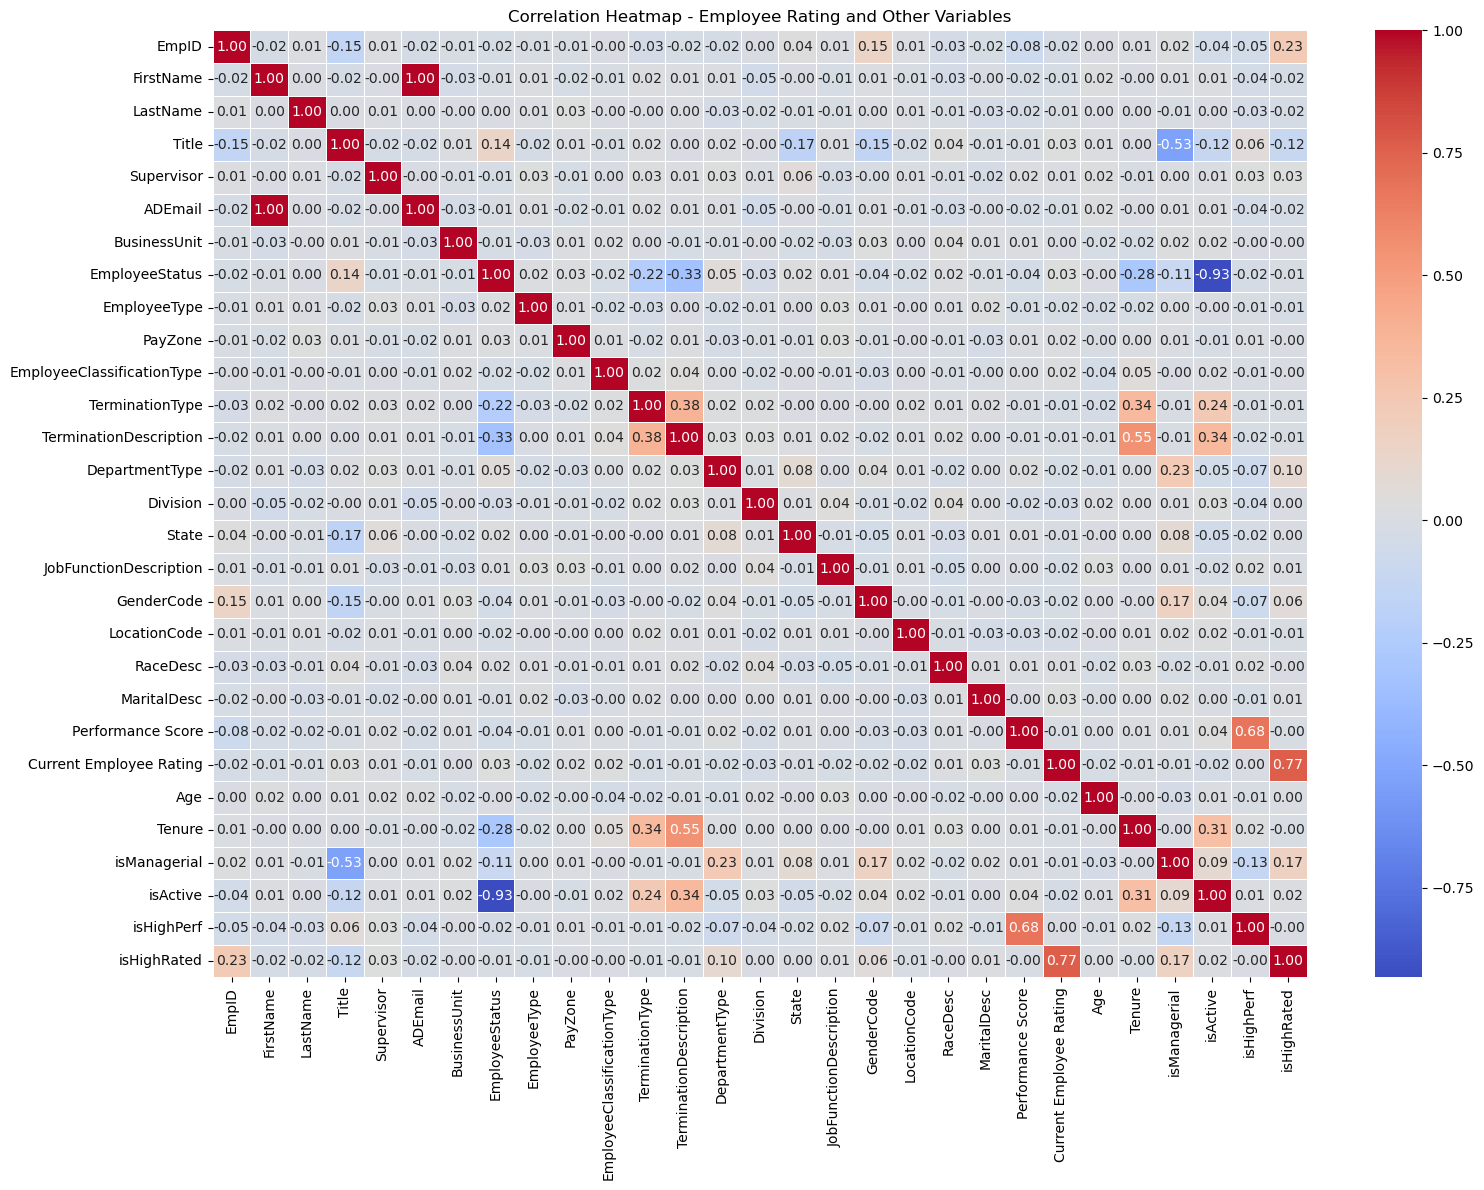

In [24]:
# Compute the correlation matrix
corr_matrix = df_employees.corr()

# Visualize the correlation matrix with a heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, linewidths=0.5)

# Add title and labels
plt.title('Correlation Heatmap - Employee Rating and Other Variables')
plt.tight_layout()
plt.show()

## EDA - Employee Demographics

Gender and Job title appears to be correlated to some extent

In [25]:
# Demographics
df_employees.corr()['GenderCode'].abs().sort_values(ascending=False)

C:\Users\Zach Chen\AppData\Local\Temp\ipykernel_20144\3887611013.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_employees.corr()['GenderCode'].abs().sort_values(ascending=False)


GenderCode                    1.000000
isManagerial                  0.166059
Title                         0.149737
EmpID                         0.146834
isHighPerf                    0.073850
isHighRated                   0.061155
State                         0.045321
isActive                      0.042103
EmployeeStatus                0.042005
DepartmentType                0.035915
BusinessUnit                  0.031587
EmployeeClassificationType    0.027826
Performance Score             0.026269
Current Employee Rating       0.017962
TerminationDescription        0.016520
JobFunctionDescription        0.014166
Division                      0.013696
RaceDesc                      0.013096
FirstName                     0.010578
ADEmail                       0.010415
EmployeeType                  0.007174
PayZone                       0.006470
LastName                      0.004667
Supervisor                    0.004426
MaritalDesc                   0.004183
TerminationType          

No strong correlation between Age and any other variables

In [26]:
df_employees.corr()['Age'].abs().sort_values(ascending=False)

C:\Users\Zach Chen\AppData\Local\Temp\ipykernel_20144\1382102927.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_employees.corr()['Age'].abs().sort_values(ascending=False)


Age                           1.000000
EmployeeClassificationType    0.039699
JobFunctionDescription        0.033129
isManagerial                  0.027105
TerminationType               0.023164
Supervisor                    0.022625
EmployeeType                  0.022324
FirstName                     0.019671
ADEmail                       0.019539
RaceDesc                      0.016576
Division                      0.016365
BusinessUnit                  0.016357
Current Employee Rating       0.015349
Title                         0.014130
DepartmentType                0.013104
isHighPerf                    0.008994
isActive                      0.007290
TerminationDescription        0.006242
PayZone                       0.004632
MaritalDesc                   0.004440
isHighRated                   0.003545
EmployeeStatus                0.003063
LocationCode                  0.002560
GenderCode                    0.002311
Performance Score             0.001538
LastName                 

No strong correlation between Marital Status and any other variables

In [27]:
df_employees.corr()['MaritalDesc'].abs().sort_values(ascending=False)

C:\Users\Zach Chen\AppData\Local\Temp\ipykernel_20144\55231829.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_employees.corr()['MaritalDesc'].abs().sort_values(ascending=False)


MaritalDesc                   1.000000
LocationCode                  0.032536
LastName                      0.031864
PayZone                       0.029293
Current Employee Rating       0.026337
EmployeeType                  0.023416
Supervisor                    0.021956
isManagerial                  0.021000
TerminationType               0.017791
EmpID                         0.015128
RaceDesc                      0.013136
isHighPerf                    0.012531
isHighRated                   0.011296
BusinessUnit                  0.009307
Title                         0.008304
State                         0.007524
EmployeeStatus                0.006039
EmployeeClassificationType    0.004795
Age                           0.004440
GenderCode                    0.004183
Division                      0.003533
Tenure                        0.003269
DepartmentType                0.003037
ADEmail                       0.002473
JobFunctionDescription        0.001978
FirstName                

In [28]:
df_employees.corr()['Tenure'].abs().sort_values(ascending=False)

C:\Users\Zach Chen\AppData\Local\Temp\ipykernel_20144\3628003641.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_employees.corr()['Tenure'].abs().sort_values(ascending=False)


Tenure                        1.000000
TerminationDescription        0.547333
TerminationType               0.341283
isActive                      0.305629
EmployeeStatus                0.282233
EmployeeClassificationType    0.052227
RaceDesc                      0.028979
BusinessUnit                  0.022886
isHighPerf                    0.021766
EmployeeType                  0.018679
LocationCode                  0.013059
Current Employee Rating       0.010242
EmpID                         0.009244
Supervisor                    0.007973
Performance Score             0.005175
State                         0.004984
DepartmentType                0.004933
isHighRated                   0.004770
Division                      0.004748
PayZone                       0.003544
isManagerial                  0.003358
MaritalDesc                   0.003269
ADEmail                       0.003242
FirstName                     0.003083
GenderCode                    0.002307
Title                    

In [29]:
df_employees.corr()['PayZone'].abs().sort_values(ascending=False)

C:\Users\Zach Chen\AppData\Local\Temp\ipykernel_20144\2218209642.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_employees.corr()['PayZone'].abs().sort_values(ascending=False)


PayZone                       1.000000
MaritalDesc                   0.029293
LastName                      0.028961
JobFunctionDescription        0.028116
DepartmentType                0.025395
EmployeeStatus                0.025284
Current Employee Rating       0.017401
FirstName                     0.016430
ADEmail                       0.016335
TerminationType               0.015358
EmployeeClassificationType    0.013669
BusinessUnit                  0.013636
Supervisor                    0.012389
isActive                      0.011965
TerminationDescription        0.011586
Division                      0.010973
Title                         0.010616
EmployeeType                  0.008830
Performance Score             0.008671
isHighPerf                    0.008173
GenderCode                    0.006470
EmpID                         0.006287
State                         0.005912
isManagerial                  0.005463
RaceDesc                      0.005282
Age                      

## Hiring Analysis


Number of employees joining the company each month ranges between 40 - 60 from Aug 2018 to Jul 2023 but suddenly plunged below 20 in Aug 2023, suggesting some unusual internal or external events having impacted hiring. 

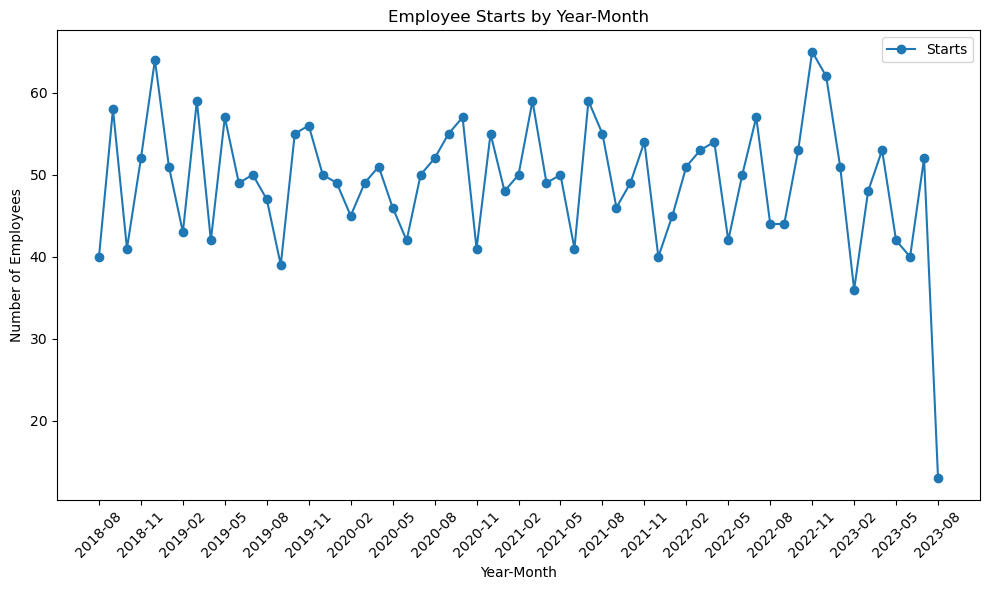

In [30]:
# Extract year and month from 'StartDate' and 'ExitDate'
df_employees['StartYearMonth'] = df_employees['StartDate'].dt.to_period('M')
df_employees['ExitYearMonth'] = df_employees['ExitDate'].dt.to_period('M')

# Count the number of starts and exits by year-month
start_counts = df_employees.groupby('StartYearMonth').size()
exit_counts = df_employees.groupby('ExitYearMonth').size()

# Plot the timeseries
plt.figure(figsize=(10, 6))
plt.plot(start_counts.index.astype(str), start_counts.values, label='Starts', marker='o')

# Add labels and title
plt.xlabel('Year-Month')
plt.ylabel('Number of Employees')
plt.title('Employee Starts by Year-Month')

# Set the x-ticks to every quarter (every 3 months)
quarters = [i for i in range(0, len(start_counts.index), 3)]  # Selecting every 3rd entry (quarter)
quarter_labels = [start_counts.index[i].strftime('%Y-%m') for i in quarters]

plt.xticks(quarters, quarter_labels, rotation=45)

plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [31]:
df['EmployeeStatus'].unique()

array(['Active', 'Future Start', 'Voluntarily Terminated',
       'Leave of Absence', 'Terminated for Cause'], dtype=object)

## Attrition Analysis

Number of employees leaving the company each month has been increasing since Aug 2018.  
Pace of increase accelerated between Nov 2021 and Feb 2023 before dropping sharply in May 2023.  
These will be further analyzed in PowerBI

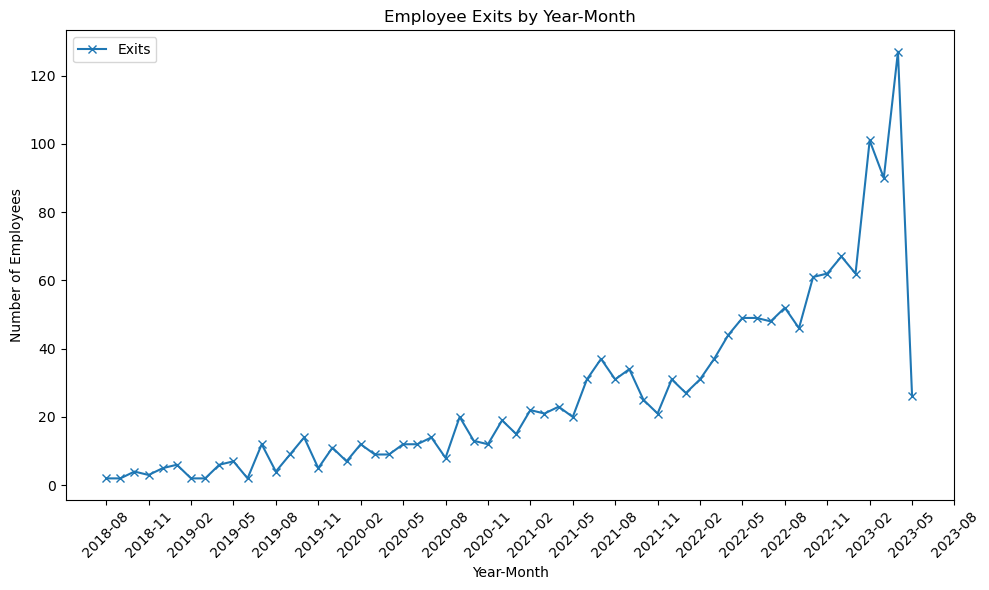

In [32]:
# Plot the exits timeseries
plt.figure(figsize=(10, 6))
plt.plot(exit_counts.index.astype(str), exit_counts.values, label='Exits', marker='x')

# Add labels and title
plt.xlabel('Year-Month')
plt.ylabel('Number of Employees')
plt.title('Employee Exits by Year-Month')

# Set the x-ticks to every quarter (every 3 months)
quarters = [i for i in range(0, len(start_counts.index), 3)]  # Selecting every 3rd entry (quarter)
quarter_labels = [start_counts.index[i].strftime('%Y-%m') for i in quarters]

plt.xticks(quarters, quarter_labels, rotation=45)

plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [33]:
# Attrition Analysis
df_employees.corr()['EmployeeStatus'].abs().sort_values(ascending=False)

C:\Users\Zach Chen\AppData\Local\Temp\ipykernel_20144\266060687.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_employees.corr()['EmployeeStatus'].abs().sort_values(ascending=False)


EmployeeStatus                1.000000
isActive                      0.933186
TerminationDescription        0.327509
Tenure                        0.282233
TerminationType               0.223952
Title                         0.141849
isManagerial                  0.109639
DepartmentType                0.048917
GenderCode                    0.042005
Performance Score             0.041124
Current Employee Rating       0.032179
Division                      0.028929
PayZone                       0.025284
isHighPerf                    0.021627
State                         0.021115
EmployeeClassificationType    0.018637
EmployeeType                  0.017176
LocationCode                  0.016739
RaceDesc                      0.015352
EmpID                         0.015108
BusinessUnit                  0.014259
JobFunctionDescription        0.013830
Supervisor                    0.011974
isHighRated                   0.010712
ADEmail                       0.007773
FirstName                

## Performance Analysis

In [34]:
df_employees.corr()['Current Employee Rating'].abs().sort_values(ascending=False)

C:\Users\Zach Chen\AppData\Local\Temp\ipykernel_20144\4093651295.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_employees.corr()['Current Employee Rating'].abs().sort_values(ascending=False)


Current Employee Rating       1.000000
isHighRated                   0.765506
EmployeeStatus                0.032179
Division                      0.030893
Title                         0.027018
MaritalDesc                   0.026337
LocationCode                  0.022504
EmpID                         0.021722
isActive                      0.020319
EmployeeType                  0.019119
EmployeeClassificationType    0.018446
GenderCode                    0.017962
PayZone                       0.017401
DepartmentType                0.015922
JobFunctionDescription        0.015610
Age                           0.015349
ADEmail                       0.014850
FirstName                     0.014701
TerminationType               0.013405
RaceDesc                      0.011974
Tenure                        0.010242
isManagerial                  0.009524
TerminationDescription        0.008285
LastName                      0.007858
State                         0.007541
Supervisor               

In [35]:
df_employees.corr()['isHighRated'].abs().sort_values(ascending=False)

C:\Users\Zach Chen\AppData\Local\Temp\ipykernel_20144\3862248805.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_employees.corr()['isHighRated'].abs().sort_values(ascending=False)


isHighRated                   1.000000
Current Employee Rating       0.765506
EmpID                         0.229575
isManagerial                  0.166997
Title                         0.116186
DepartmentType                0.095460
GenderCode                    0.061155
Supervisor                    0.031326
LastName                      0.024270
FirstName                     0.020956
ADEmail                       0.020952
isActive                      0.015406
EmployeeType                  0.012370
TerminationDescription        0.011537
MaritalDesc                   0.011296
EmployeeStatus                0.010712
LocationCode                  0.008737
TerminationType               0.008132
JobFunctionDescription        0.005115
Performance Score             0.004839
Tenure                        0.004770
isHighPerf                    0.004215
Age                           0.003545
State                         0.002745
Division                      0.002346
EmployeeClassificationTyp

In [36]:
df_employees.corr()['Performance Score'].abs().sort_values(ascending=False)

C:\Users\Zach Chen\AppData\Local\Temp\ipykernel_20144\2570186498.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_employees.corr()['Performance Score'].abs().sort_values(ascending=False)


Performance Score             1.000000
isHighPerf                    0.675656
EmpID                         0.079847
EmployeeStatus                0.041124
isActive                      0.036155
LocationCode                  0.027371
GenderCode                    0.026269
FirstName                     0.023790
ADEmail                       0.023444
Division                      0.023028
LastName                      0.022051
DepartmentType                0.019282
Supervisor                    0.018215
EmployeeType                  0.013909
isManagerial                  0.010051
RaceDesc                      0.009793
PayZone                       0.008671
BusinessUnit                  0.007371
TerminationType               0.005952
Current Employee Rating       0.005827
Title                         0.005598
TerminationDescription        0.005381
State                         0.005204
Tenure                        0.005175
isHighRated                   0.004839
EmployeeClassificationTyp

# Output data for analysis in PowerBI

In [1]:
# Output df to CSV file for further analysis
# df_emp_bef_encoding.to_csv('df_emp_bef_encoding.csv', index=False)